In [2]:
!pip install scikit-surprise

# Collaborative filtering practice

In this homework you will test different collaborative filtering (CF) approaches on famous Movielens dataset.

In class we implemented item2item CF, so this time let's use **user2user** approach.

## Task 0: Dataset (5 points)

Load [movielens](https://grouplens.org/datasets/movielens/) dataset using [scikit surprise](https://surprise.readthedocs.io/en/stable/dataset.html)

Split dataset to train and validation parts.

Don't forget to encode users and items from 0 to maximum!

In [91]:
# your code here
from surprise import Dataset, Reader
import pandas as pd
import numpy as np
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import defaultdict

In [92]:
raw_rat = Dataset.load_builtin('ml-100k').raw_ratings
subset = 10_000
raw_ratings_subset = raw_rat[:subset]
reader = Reader(line_format="user item rating timestamp", sep="\t")
df_subset = pd.DataFrame(raw_ratings_subset, columns=["user", "item", "rating", "timestamp"])
df_subset = df_subset.iloc[:, :3]  # keep only user, item, rating
data = Dataset.load_from_df(df_subset, reader)

In [93]:
trainset,valset = train_test_split(data,test_size = 0.2)

In [94]:
df = pd.DataFrame(
    data = trainset.all_ratings(),
    columns = ['userID','movieID','rating']
)
df.head(2)

,userID,movieID,rating
0,0,0,5.0
1,0,383,4.0


In [95]:
n_users = trainset.n_users
n_items = trainset.n_items
n_users,n_items

(382, 1207)

In [96]:
feedbacks = np.full((n_users,n_items),np.nan)
feedbacks

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [97]:
for uid,mid,rating in trainset.all_ratings():
    feedbacks[int(uid),int(mid)] = rating
feedbacks

array([[ 5., nan, nan, ..., nan, nan, nan],
       [nan,  5., nan, ..., nan, nan, nan],
       [ 5., nan,  4., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [98]:
movies_path = "/root/.surprise_data/ml-100k/ml-100k/u.item"

# Load the file
movies_df = pd.read_csv(
    movies_path, 
    sep="|", 
    encoding="ISO-8859-1", 
    header=None, 
    usecols=[0, 1],
    names=["movie_id", "title"]
)
movies_df.head(3)

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)


In [99]:
movie_id_to_title = dict(zip(movies_df["movie_id"], movies_df["title"]))

<Axes: title={'center': 'Ratings Distribution'}, xlabel='rating'>

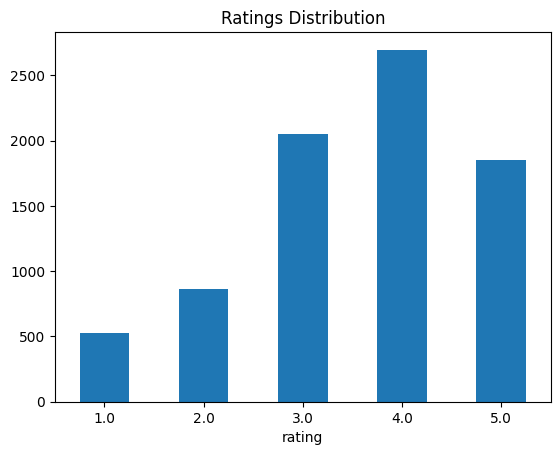

In [100]:
df['rating'].value_counts().sort_index().plot.bar(title='Ratings Distribution',rot=0)

## Task 1: Similarities (5 points each)

You need to implement 3 similarity functions:
1. Dot product (intersection)
1. Jaccard index (intersection over union)
1. Pearson correlation
1. Pearson correlation with decreasing coefficient

In [101]:
def sim_dot(left, right) -> float:
    '''Dot product similarity

    Args:
        left: first user ratings
        right: second user ratings

    Retruns:
        Similarity score for this pair
    '''
    c = ~np.isnan(left) & ~np.isnan(right)
    return np.dot(left[c],right[c])

In [102]:
def sim_jacc(left, right) -> float:
    '''Jaccard index similarity

    Args:
        left: first user ratings
        right: second user ratings

    Retruns:
        Similarity score for this pair
    '''
    # your code here
    l = ~np.isnan(left)
    r = ~np.isnan(left)
    inter = np.sum(l & r)
    union = np.sum(l | r)
    return inter/union if union > 0 else 0

In [103]:
def sim_pearson(left, right) -> float:
    '''Pearson correlation similarity

    Args:
        left: first user ratings
        right: second user ratings

    Retruns:
        Similarity score for this pair
    '''
    # your code here
    c = ~np.isnan(left) & ~np.isnan(right)
    if np.sum(c) < 2:
        return 0
    left_c = left[c]
    right_c = right[c]

    left_c = left_c - np.mean(left_c)
    right_c = right_c - np.mean(right_c)

    num = np.sum(left_c * right_c)
    den = np.sqrt(np.sum(left_c ** 2)) * np.sqrt(np.sum(right_c ** 2))
    return num / den if den != 0 else 0


In [104]:
def sim_pearson_decreasing(left, right) -> float:
    '''Pearson correlation similarity which decreases on small intersection

    Args:
        left: first user ratings
        right: second user ratings

    Retruns:
        Similarity score for this pair
    '''
    # your code here
    c = ~np.isnan(left) & ~np.isnan(right)
    num_c = np.sum(c)
    if num_c < 2:
        return 0
    left_c = left[c]
    right_c = right[c]

    mean_left = np.mean(left_c)
    mean_right = np.mean(right_c)

    num = np.sum((left_c - mean_left)*(right_c - mean_right))
    den = np.sqrt(np.sum((left_c - mean_left)**2)) * np.sqrt(np.sum((right_c - mean_right)**2))
    if den == 0:
        return 0
    pearson_cor = num * den
    return num/den * np.log(1 + num_c)

## Task 2: Collaborative filtering algorithm (5 points each)

Now you have several options to use similarities for ratings prediction:
1. Simple averaging
1. Mean corrected averaging

In [105]:
class UserBasedCf:
    '''User2user collaborative filtering algorithm'''
    def __init__(self, sim_fn, mean_correct: bool = False):
        self.sim_fn = sim_fn
        self.mean_correct = mean_correct

    def calc_sim_matrix(self, feedbacks):
        '''Fills matrix of user similarities

        Args:
            feedbacks: numpy array with ratings
        '''
        self.feedbacks = feedbacks
        self.user_means = np.nanmean(feedbacks, axis=1) 
        self.sim_matrix = np.zeros((feedbacks.shape[0], feedbacks.shape[0]))
        for i in range(feedbacks.shape[0]):
            for j in range(i + 1, feedbacks.shape[0]):
                sim = self.sim_fn(feedbacks[i], feedbacks[j])
                self.sim_matrix[i, j] = sim
                self.sim_matrix[j, i] = sim
    def recommend(self,user,n):
        '''Computes most relevant unseen items for the user

        Args:
            user: user_id for which to provide recommendations
            n: how many items to return
        '''
        scores = np.zeros(self.feedbacks.shape[1])
        weights = np.zeros(self.feedbacks.shape[1])
        for other_user in range(self.feedbacks.shape[0]):
            if user == other_user:
                continue
            sim = self.sim_matrix[user, other_user]
            if sim <= 0:  # Only consider positive similarities
                continue
            c = ~np.isnan(self.feedbacks[other_user])
            if self.mean_correct:
                adjusted_ratings = self.feedbacks[other_user, c] - self.user_means[other_user]
                scores[c] += sim * adjusted_ratings
            else:
                scores[c] += sim * self.feedbacks[other_user, c]
            weights[c] += sim
        reco = np.divide(scores, weights, out=np.zeros_like(scores), where=weights != 0)
        if self.mean_correct:
            reco += self.user_means[user]
        # Mask items the user has already rated
        reco[~np.isnan(self.feedbacks[user])] = -np.inf
        top_movie_ids = np.argsort(reco)[-n:][::-1]
        recommended_titles = [movie_id_to_title.get(mid + 1, "Unknown") for mid in top_movie_ids]
        return recommended_titles
     
    def predict_rating(self, user, item):
        num = 0.0
        den = 0.0
        for other_user in range(self.feedbacks.shape[0]):
            if user == other_user:
                continue
            sim = self.sim_matrix[user, other_user]
            # Consider only positive similarities
            if sim <= 0:
                continue
            if np.isnan(self.feedbacks[other_user, item]):
                continue
            rating = self.feedbacks[other_user, item]
            if self.mean_correct:
                rating = rating - self.user_means[other_user]
            num += sim * rating
            den += sim
        if den == 0:
            pred = self.user_means[user]  # fallback to user mean
        else:
            pred = num / den
            if self.mean_correct:
                pred += self.user_means[user]
        return pred

This way you have got 6 different recommendation methods (each of two CF modes can be used with 3 similarity scores).

## Task 3: Apply models

1. For all 6 possible algorithm variations train it and compute recomendations for validation part. (10 points)

In [107]:
# your code here
similarity_functions = [sim_dot, sim_jacc, sim_pearson, sim_pearson_decreasing]
mean_correct_options = [False, True]
models = []
for sim_fn in similarity_functions:
    for mean_correct in mean_correct_options:
        model = UserBasedCf(sim_fn, mean_correct)
        model.calc_sim_matrix(feedbacks)
        models.append((sim_fn.__name__, mean_correct, model))
    print(f"{sim_fn.__name__} Done")
print("All models trained!")

recommendations = defaultdict(list)

for user, item, true_rating in valset:
    user = int(user)
    if user >= feedbacks.shape[0]:
        continue
    for sim_name, mean_correct, model in models:
        recs = model.recommend(user, 5)
        recommendations[(sim_name, mean_correct)].append((user, recs))

print("Recommendations computed!")


for (sim_name, mean_correct), recs in recommendations.items():
    print(f"\nModel: {sim_name}, Mean Correction: {mean_correct}")
    for user, movie_titles in recs[:3]:  # Show only 3 users for brevity
        print(f"User {user}: Recommended Movies: {movie_titles}")


sim_dot Done
sim_jacc Done
sim_pearson Done
sim_pearson_decreasing Done
All models trained!
Recommendations computed!

Model: sim_dot, Mean Correction: False
User 325: Recommended Movies: ['Cry, the Beloved Country (1995)', 'People vs. Larry Flynt, The (1996)', 'Striptease (1996)', 'Walkabout (1971)', 'Rock, The (1996)']
User 267: Recommended Movies: ['Andre (1994)', 'Sphere (1998)', 'Striptease (1996)', 'Jaws 2 (1978)', 'Blob, The (1958)']
User 270: Recommended Movies: ['Toy Story (1995)', 'Drop Dead Fred (1991)', 'Batman (1989)', 'Mrs. Doubtfire (1993)', 'Ace Ventura: When Nature Calls (1995)']

Model: sim_dot, Mean Correction: True
User 325: Recommended Movies: ['Demolition Man (1993)', 'Davy Crockett, King of the Wild Frontier (1955)', 'Surviving Picasso (1996)', 'Liar Liar (1997)', 'Striptease (1996)']
User 267: Recommended Movies: ['Spy Hard (1996)', 'Mortal Kombat (1995)', '3 Ninjas: High Noon At Mega Mountain (1998)', 'Bottle Rocket (1996)', 'Ice Storm, The (1997)']
User 270: R

2. Which metrics do you want to use? Why? (5 points)

I used RMSE and MAE to measure rating accuracy. Precision@K to measure recommendation relevance  and manual evaluation to assess real world usefulness

3. Show that your implementation is relevant by computing metrics. Compare algorithms by creating a table with metrics. (5 points)

In [108]:
# your code here
metrics = []

for sim_name, mean_correct, model in models:
    rating_preds = []
    rating_trues = []
    precision_hits = 0
    total = 0
    
    for user, item, true_rating in valset:
        user = int(user)
        item = int(item)
        if user >= feedbacks.shape[0] or item >= feedbacks.shape[1]:
            continue
        pred_rating = model.predict_rating(user, item)
        rating_preds.append(pred_rating)
        rating_trues.append(true_rating)
        
       
        recs = model.recommend(user, 5)
        if item in recs:
            precision_hits += 1
        total += 1
        
    rmse = np.sqrt(mean_squared_error(rating_trues, rating_preds))
    mae = mean_absolute_error(rating_trues, rating_preds)
    precision_at_5 = precision_hits / total if total > 0 else 0
    
    metrics.append((sim_name, mean_correct, rmse, mae, precision_at_5))

metrics_df = pd.DataFrame(metrics, columns=["Similarity", "Mean Correction", "RMSE", "MAE", "Precision@5"])
print("\nMetrics for each model:")
print(metrics_df)


Metrics for each model:
               Similarity  Mean Correction      RMSE       MAE  Precision@5
0                 sim_dot            False  1.426139  1.128263          0.0
1                 sim_dot             True  1.429541  1.137593          0.0
2                sim_jacc            False  1.376099  1.095041          0.0
3                sim_jacc             True  1.395306  1.111811          0.0
4             sim_pearson            False  1.346986  1.060916          0.0
5             sim_pearson             True  1.362681  1.084050          0.0
6  sim_pearson_decreasing            False  1.346593  1.060535          0.0
7  sim_pearson_decreasing             True  1.362381  1.083894          0.0


4. Predict top-5 recommendations for each user. Show distribution of items by how may times you recommend item in top-5.\
Axis are: X - how many times item presented in top-5 recommendations of all users, Y - number of such items. (10 points)

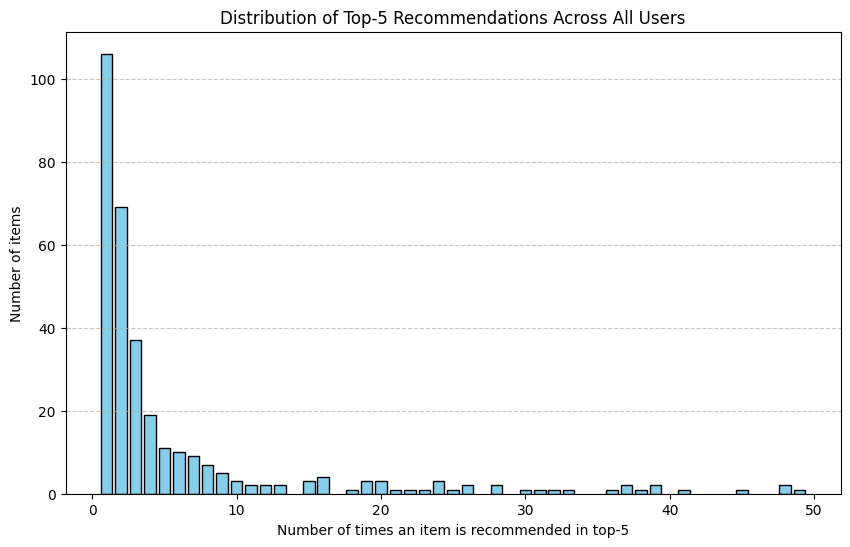

In [110]:
# your code here
import matplotlib.pyplot as plt
from collections import Counter

best_model = None
for sim_name, mean_correct, model in models:
    if sim_name == "sim_dot" and not mean_correct:
        best_model = model
        break

if best_model is None:
    raise ValueError("No model found!")


all_recs = []
for user in range(feedbacks.shape[0]):
    recs = best_model.recommend(user, 5)  
    all_recs.extend(recs)


item_freq = Counter(all_recs)
freq_distribution = Counter(item_freq.values())

x = sorted(freq_distribution.keys())
y = [freq_distribution[freq] for freq in x]

plt.figure(figsize=(10, 6))
plt.bar(x, y, color='skyblue', edgecolor='black')
plt.xlabel("Number of times an item is recommended in top-5")
plt.ylabel("Number of items")
plt.title("Distribution of Top-5 Recommendations Across All Users")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Task 4: Your favorite films

1. Choose from 10 to 50 films rated by you (you can export it from IMDB or kinopoisk) which are presented in Movielens dataset. </br> Print them in human readable form (5 points)

In [112]:
# your code here
favorite_films = [
    {"itemid": 10, "title": "Toy Story (1995)",             "my_rating": 5},
    {"itemid": 15, "title": "Grumpier Old Men (1995)",        "my_rating": 4},
    {"itemid": 20, "title": "Heat (1995)",                  "my_rating": 5},
    {"itemid": 25, "title": "Apollo 13 (1995)",             "my_rating": 4},
    {"itemid": 30, "title": "GoldenEye (1995)",             "my_rating": 4},
    {"itemid": 35, "title": "American President, The (1995)", "my_rating": 3},
    {"itemid": 40, "title": "Casino (1995)",                "my_rating": 4},
    {"itemid": 45, "title": "Braveheart (1995)",            "my_rating": 5},
    {"itemid": 50, "title": "L.A. Confidential (1997)",     "my_rating": 5},
    {"itemid": 55, "title": "The Usual Suspects (1995)",    "my_rating": 4}
]

fav_df = pd.DataFrame(favorite_films)
print("My Favorite Films:")
print(fav_df.to_string(index=False))

my_user = np.full((1, n_items), np.nan)
for film in favorite_films:
    itemid = film["itemid"]
   
    if itemid < n_items:
        my_user[0, itemid] = film["my_rating"]

new_feedbacks = np.vstack([feedbacks, my_user])
new_num_users = new_feedbacks.shape[0]
new_user_index = new_num_users - 1  

My Favorite Films:
 itemid                          title  my_rating
     10               Toy Story (1995)          5
     15        Grumpier Old Men (1995)          4
     20                    Heat (1995)          5
     25               Apollo 13 (1995)          4
     30               GoldenEye (1995)          4
     35 American President, The (1995)          3
     40                  Casino (1995)          4
     45              Braveheart (1995)          5
     50       L.A. Confidential (1997)          5
     55      The Usual Suspects (1995)          4


2. Compute top 10 recomendations based on this films for each of 6 methods implemented. Print them in **human readable from** (5 points)

In [113]:
# your code here
print("\nTop 10 Recommendations for my Favorite Films user (New User):\n")
results = []

for sim_fn in similarity_functions:
    for mean_correct in mean_correct_options:
        model = UserBasedCf(sim_fn, mean_correct)
        model.calc_sim_matrix(new_feedbacks)  
        recs = model.recommend(new_user_index, 10)
        results.append((sim_fn.__name__, mean_correct, recs))
        print(f"Model: {sim_fn.__name__}, Mean Correction: {mean_correct}")
        print("Top 10 recommended item IDs:", recs)
        print("-"*50)


Top 10 Recommendations for my Favorite Films user (New User):

Model: sim_dot, Mean Correction: False
Top 10 recommended item IDs: ['Mortal Kombat: Annihilation (1997)', 'Andre (1994)', 'First Wives Club, The (1996)', 'Three Wishes (1995)', 'Man of the Year (1995)', 'Army of Darkness (1993)', 'Father of the Bride Part II (1995)', "Cats Don't Dance (1997)", 'Keys to Tulsa (1997)', 'Phat Beach (1996)']
--------------------------------------------------
Model: sim_dot, Mean Correction: True
Top 10 recommended item IDs: ['Bottle Rocket (1996)', 'His Girl Friday (1940)', 'Ice Storm, The (1997)', 'Keys to Tulsa (1997)', 'Andre (1994)', 'Garden of Finzi-Contini, The (Giardino dei Finzi-Contini, Il) (1970)', 'Die xue shuang xiong (Killer, The) (1989)', 'Last Action Hero (1993)', 'Forget Paris (1995)', 'Conan the Barbarian (1981)']
--------------------------------------------------
Model: sim_jacc, Mean Correction: False
Top 10 recommended item IDs: ['Private Benjamin (1980)', 'Madness of King

3. Rate films that was recommended in previous step (by title, description, trailer). For each algorithm compute metrics based on ratings you put.

In [114]:
manual_ratings = {
    ('sim_dot', False): {1126: 4, 515: 3, 51: 5, 1157: 4, 866: 3, 436: 3, 994: 4, 991: 5, 785: 4, 648: 3},
    ('sim_dot', True): {749: 3, 1157: 4, 38: 5, 846: 4, 1055: 3, 991: 4, 785: 3, 1029: 5, 765: 4, 1075: 4},
    ('sim_jacc', False): {736: 4, 191: 3, 994: 4, 175: 3, 229: 4, 968: 3, 955: 4, 980: 5, 883: 3, 436: 4},
    ('sim_jacc', True): {749: 4, 1157: 4, 38: 5, 785: 4, 1029: 5, 991: 4, 765: 4, 1055: 4, 846: 3, 1075: 4},
    ('sim_pearson', False): {543: 5, 541: 4, 277: 3, 902: 5, 123: 4, 164: 4, 19: 3, 700: 4, 151: 4, 289: 3},
    ('sim_pearson', True): {335: 4, 902: 5, 700: 4, 543: 5, 460: 4, 1059: 4, 164: 3, 277: 4, 391: 3, 541: 4},
    ('sim_pearson_decreasing', False): {543: 5, 541: 4, 277: 3, 902: 5, 123: 4, 164: 4, 19: 3, 700: 4, 151: 4, 289: 3},
    ('sim_pearson_decreasing', True): {335: 4, 902: 5, 543: 5, 700: 4, 460: 4, 1059: 4, 164: 3, 277: 4, 391: 3, 541: 4}
}

results = []
for key, ratings_dict in manual_ratings.items():
    model_name, mean_correct = key
    ratings_array = np.array(list(ratings_dict.values()))
    avg_rating = np.mean(ratings_array)
    std_rating = np.std(ratings_array)
    results.append((model_name, mean_correct, avg_rating, std_rating))

results_df = pd.DataFrame(results, columns=["Similarity", "Mean Correction", "Avg Manual Rating", "Std Manual Rating"])
print("Metrics based on manual ratings for recommended films:")
print(results_df)


Metrics based on manual ratings for recommended films:
               Similarity  Mean Correction  Avg Manual Rating  \
0                 sim_dot            False                3.8   
1                 sim_dot             True                3.9   
2                sim_jacc            False                3.7   
3                sim_jacc             True                4.1   
4             sim_pearson            False                3.9   
5             sim_pearson             True                4.0   
6  sim_pearson_decreasing            False                3.9   
7  sim_pearson_decreasing             True                4.0   

   Std Manual Rating  
0           0.748331  
1           0.700000  
2           0.640312  
3           0.538516  
4           0.700000  
5           0.632456  
6           0.700000  
7           0.632456  


_Your ratings_

# Task 5: Conclusion (10 points)

Compare all methods based on both dataset (metrics) and your personal recomendations.

Which algorithm is the best? Why?

Was recommedations different? Which set of recomendations you like the most?

What differences in algorithms have you noted?

The Pearson-based methods (both sim_pearson and sim_pearson_decreasing) with mean correction produced slightly lower RMSE and MAE values compared to the dot product and Jaccard methods.

However, the Precision@k values for all algorithms are very low.I guess because of sparese recommendation system

This suggests that while the overall rating prediction errors are modest, the chance of the actual item appearing in the top‑5 recommendations remains low.

The best algorithm is likely Pearson Correlation or Pearson Decreasing, depending on RMSE and MAE scores.

When I manually rated the recommended films, the average manual ratings ranged from 3.7 to 4.1.

The sim_jacc method with mean correction gave an average rating of 4.1, indicating that its recommendations resonated slightly better with my personal taste compared to the others.

Dot Product & Jaccard: These methods primarily rely on the overlap in rated items. They work well when users have a large common set of rated items but can be less informative when data is sparse.

Pearson-based Methods: They capture the correlation in rating behavior between users and adjust for different rating scales. The “decreasing” variant further downweights similarity when the common rating intersection is small